## 1D Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP,SaasPyroModel
from botorch.fit import fit_gpytorch_model
from botorch.fit import fit_fully_bayesian_model_nuts
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
from botorch.posteriors.gpytorch import GPyTorchPosterior
import math

## Identify and plot the objective function

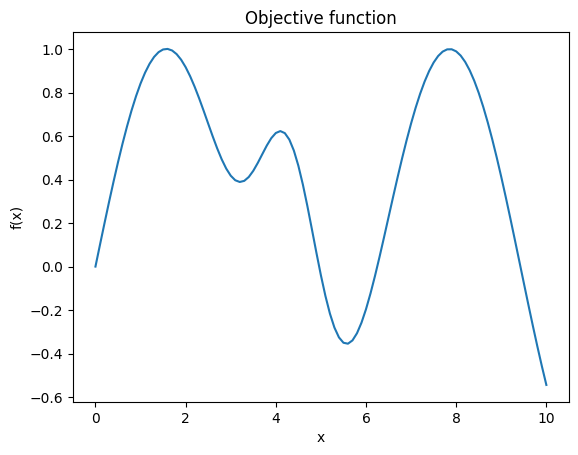

In [3]:
def F(X):
    y = []
    for x in X:
        y.append(np.sin(x) + 1.5 * np.exp(-(x - 4.3) ** 2))
    return torch.tensor(y)

x = np.linspace(0,10,101)
y = F(x)
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Objective function")
plt.show()

## Retrive initial dataset

(tensor([[5.3624],
         [7.6353],
         [4.5122],
         [8.4117],
         [6.7506]]),
 tensor([[-0.3109],
         [ 0.9762],
         [ 0.4540],
         [ 0.8485],
         [ 0.4543]]),
 0.9762099981307983)

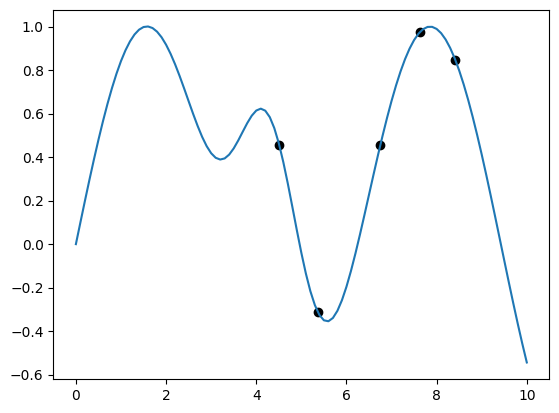

In [4]:
n = 5 # Number of training points
train_x = torch.rand(n,1)*10
train_y = F(train_x).unsqueeze(-1)
best_observed = train_y.max().item()
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(x,F(x))
plt.show
train_x,train_y,best_observed

## Fit GP model
Default:
    likelihood: standard Gaussian likelihood with inferred noise level
    Covar_module: Matern kernel
    Mean_module: Constant mean

/Users/yimengjin/Desktop/Thesis/Thesis_Yimeng/venv/lib/python3.9/site-packages/botorch/models/gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


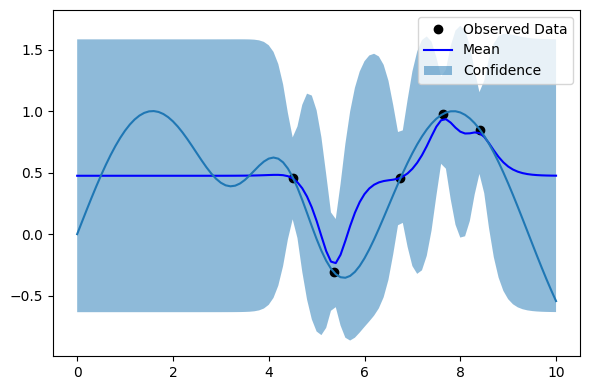

In [5]:
model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(model.likelihood,model)
fit_gpytorch_model(mll)

# Plot results
model.eval()

# Initialize plot
f,ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'ko')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Fully Bayesian GP Models (High dimensional problems)
Sample a set of hyperparameters from the posterior
Prior: sparse axis-aligned subspace priors (SAAS) model to identify the most important parameters

In [6]:
# saas_gp = SaasFullyBayesianSingleTaskGP(train_x, train_y)
# fit_fully_bayesian_model_nuts(saas_gp)
# posterior = saas_gp.posterior(test_x)

## Acquistion function
Morte-Carlo sampling:
1. Sampling joint posterior over q points
2. evaluate the current best for each sample
3. maximise over q
4. average over the samples

# EI Defaults:
1. Sampler: SobolQMCNormalSampler
2. Objective: IdentityMCObjective() (objective under which samples is evaluated)

In [7]:
EI = qExpectedImprovement(
    model = model,
    best_f = best_observed
)

## Noisy Expected Improvement:
Does not assume best_f, compute improvement over the previous points and average

In [8]:
NEI = qNoisyExpectedImprovement(
    model = model,
    X_baseline = train_x,
    prune_baseline= True,
)

## qUCB
beta: control the tradeoff between mean and variance.

In [9]:
UCB = qUpperConfidenceBound(
    model = model,
    beta = 0.6,
)

## Optimise acquisition function

In [10]:
candidates_x,_ = optimize_acqf(
    acq_function = UCB,
    bounds = torch.tensor([[0.],[10.]]),
    q = 5, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[7.9782],
         [1.0426],
         [8.8948],
         [3.4142],
         [7.3295]]),
 tensor([[0.9923],
         [0.8637],
         [0.5056],
         [0.4152],
         [0.8657]]))

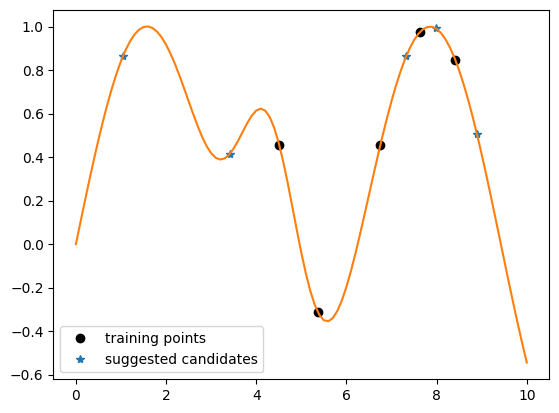

In [11]:
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.plot(x,F(x))
plt.show()

## Take in suggested data, forming new training dataset

In [12]:
combine_x = (train_x,candidates_x)
combine_y = (train_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y

(tensor([[5.3624],
         [7.6353],
         [4.5122],
         [8.4117],
         [6.7506],
         [7.9782],
         [1.0426],
         [8.8948],
         [3.4142],
         [7.3295]]),
 tensor([[-0.3109],
         [ 0.9762],
         [ 0.4540],
         [ 0.8485],
         [ 0.4543],
         [ 0.9923],
         [ 0.8637],
         [ 0.5056],
         [ 0.4152],
         [ 0.8657]]))

## Posterior model

/Users/yimengjin/Desktop/Thesis/Thesis_Yimeng/venv/lib/python3.9/site-packages/botorch/models/gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


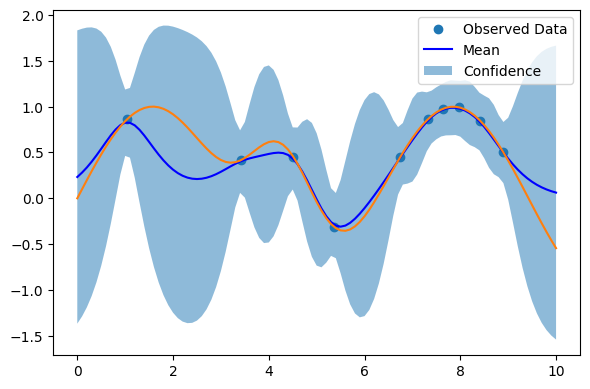

In [13]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Second run

In [14]:
EI = qExpectedImprovement(
    model = posterior_model,
    best_f = best_observed
)

In [15]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[ 1.4779],
         [ 0.0000],
         [ 4.0471],
         [ 3.8854],
         [ 1.9553],
         [ 8.1144],
         [ 0.6016],
         [10.0000],
         [ 7.7650],
         [ 2.5979]]),
 tensor([[ 9.9621e-01],
         [ 1.3995e-08],
         [ 6.2032e-01],
         [ 5.8601e-01],
         [ 9.3313e-01],
         [ 9.6629e-01],
         [ 5.6594e-01],
         [-5.4402e-01],
         [ 9.9605e-01],
         [ 6.0009e-01]]))

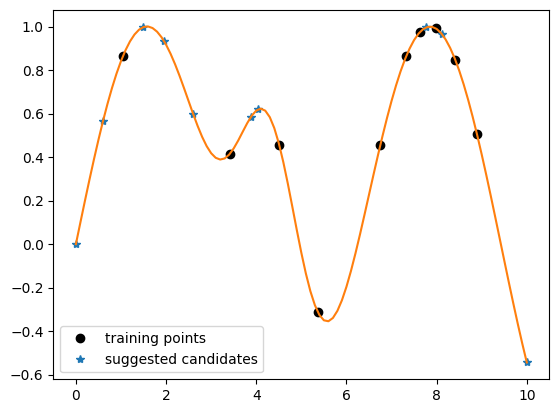

In [16]:
plt.plot(posterior_x,posterior_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.plot(x,F(x))
plt.show()

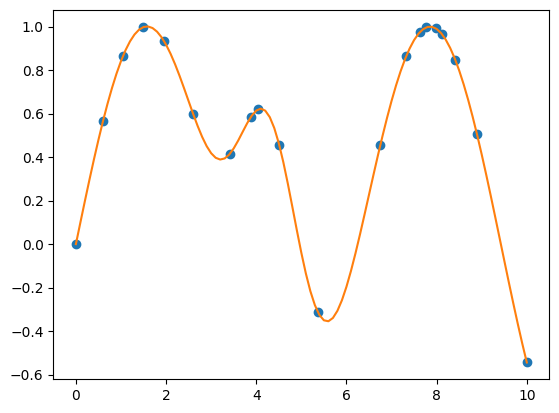

In [17]:
combine_x = (posterior_x,candidates_x)
combine_y = (posterior_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y
plt.plot(posterior_x,posterior_y,'o')
plt.plot(x,F(x))

/Users/yimengjin/Desktop/Thesis/Thesis_Yimeng/venv/lib/python3.9/site-packages/botorch/models/gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


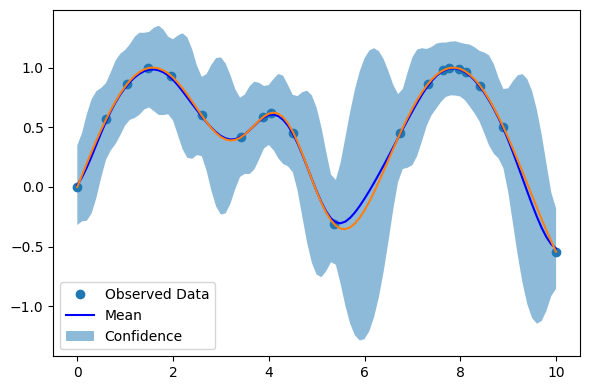

In [18]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()